<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp2/blob/main/notebooks/create_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# UBA - Maestria en Explotación de Datos y Descubrimiento de Conocimiento
### **Materia**: Datamining en Ciencia y Tecnologia
### **Trabajos Prácticos 2**: Redes de palabras

### **Grupo**

* Adrian Norberto Marino
* Claudio Collado
* Flavia Felicioni

---

## Preprocesamiento de datos

In [1]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

###  1. Descargar dataset

Se descarga el dataset y lo descomprime en `~/datasets`.

In [3]:
# Database...
dataset_filename = "SWOW-EN.R100.csv"
dataset_url      = 'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp2/main/datasets/{}.zip'.format(dataset_filename)

# Embeddings...

# Glove:
glove_embeding_filename     = "glove.840B.300d"
glove_embeding_filename_txt = glove_embeding_filename + '.txt'
glove_embeding_url          = 'https://nlp.stanford.edu/data/{}.zip'.format(glove_embeding_filename)

# Google:
google_embeding_filename    = "GoogleNews-vectors-negative300.bin.gz"
google_embeding_url         = 'https://s3.amazonaws.com/dl4j-distribution/{}'.format(google_embeding_filename)


if is_runing_into_colab_env():
    !cd ~
    !rm -rf datasets
    !rm -rf *.zip
    
    !wget  {dataset_url}
    !wget  {glove_embeding_url}
    !wget  {google_embeding_url}
    
    !unzip {dataset_filename}.zip
    !unzip {glove_embeding_filename}.zip
    !mkdir datasets

    !mv {dataset_filename} datasets
    !mv {glove_embeding_filename}.txt datasets
    !mv {google_embeding_filename} datasets

    !rm *.zip

###  2. Importa libreria del proyecto

In [4]:
if is_runing_into_colab_env():
    if path.exists('/content/dm-cyt-tp2'):
        print('Pull...\n')
        !cd dm-cyt-tp2; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp2.git

In [5]:
sys.path.append('/content/dm-cyt-tp2/src' if is_runing_into_colab_env() else '../src')
dataset_path = '/content/dm-cyt-tp2/datasets/{}' if is_runing_into_colab_env() else '../datasets/{}'

###  3. Importa paquetes externos

In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd
import networkx as nx

import logging
from logger import setup_logger

from scipy.spatial.distance import euclidean, jaccard, cosine

from distance import closest, \
                     show_closest, \
                     distance, \
                     distance_to_weight

from step import  select_columns, \
                  rename_columns, \
                  exclude_bidiredtional_associations, \
                  exclude_words_lt, \
                  exclude_stopwords, \
                  to_unique_works, \
                  to_glove_word_embeddings, \
                  lower, \
                  strip, \
                  dropna, \
                  plot_frequency, \
                  log_unique_words, \
                  log_source_into_response_and_vise_versa, \
                  n_top, \
                  all_columns_contains, \
                  append_calculated_column, \
                  append_source_response_freqs, \
                  select, \
                  distinct, \
                  exclude_loops

from embedding import GoogleW2VSimilarity
from dataset import summary

[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
setup_logger(format = '%(levelname)s: %(message)s')

###  4. Preprocesar dataset

En este paso seleccionamos las columnas **cue** y **R1**, las renombramos a **source** y **response**. Luego minisculizamos y quitamos espacios. Filtramos las palabras de menos de 2 letras, filtramos las filas con nulos. Por último filtramos stop words por varios lenguajes.

In [8]:
def load_dataset(filename): return pd.read_csv(dataset_path.format(filename))

In [9]:
dataset = load_dataset(dataset_filename) \
    .pipe(select_columns) \
    .pipe(rename_columns, {'cue': 'source', 'R1': 'response'}) \
    .pipe(lower) \
    .pipe(strip) \
    .pipe(log_unique_words) \
    .pipe(log_source_into_response_and_vise_versa, unique=True) \
    .pipe(log_source_into_response_and_vise_versa, unique=False) \
    .pipe(exclude_words_lt, size_less_than=2) \
    .pipe(dropna) \
    .pipe(exclude_stopwords, column = 'source') \
    .pipe(exclude_stopwords, column = 'response') \
    .pipe(distinct) \
    .pipe(exclude_loops)

INFO: (1228200, 13) --> select_columns({}) --> (1228200, 2)
INFO: (1228200, 2) --> rename_columns({}) --> (1228200, 2)
INFO: (1228200, 2) --> lower({}) --> (1228200, 2)
INFO: (1228200, 2) --> strip({}) --> (1228200, 2)
INFO: Unique - Source: 12282, Response: 63715
INFO: Unique: True, Source into response: 1104304, Response into source: 1219500
INFO: Unique: False, Source into response: 123896, Response into source: 8700
INFO: (1228200, 2) --> exclude_words_lt({'size_less_than': 2}) --> (1225128, 2)
INFO: (1225128, 2) --> dropna({}) --> (1194119, 2)
INFO: (1194119, 2) --> exclude_stopwords({'languages': ['arabic']}) --> (1194119, 2)
INFO: (1194119, 2) --> exclude_stopwords({'languages': ['azerbaijani']}) --> (1193633, 2)
INFO: (1193633, 2) --> exclude_stopwords({'languages': ['bengali']}) --> (1193633, 2)
INFO: (1193633, 2) --> exclude_stopwords({'languages': ['danish']}) --> (1191959, 2)
INFO: (1191959, 2) --> exclude_stopwords({'languages': ['dutch']}) --> (1190828, 2)
INFO: (1190828,

###  5. Generar un dicionario de embedding a partir de Glove

A continuacion se genera un diccionario donde la calse es una palabra y el valor es un vector embedding. Ademas solo genermos este doccionario para las palabar que se encuentran en el dataset inicial.

In [10]:
glove_word_embeddings = dataset \
    .pipe(to_unique_works) \
    .pipe(to_glove_word_embeddings, file_path = dataset_path.format(glove_embeding_filename_txt))

INFO: (462439, 2) --> to_unique_works({}) --> (462433, 1)


  0%|          | 0/462433 [00:00<?, ?it/s]

INFO: Found 5675 words.
INFO: (462433, 1) --> to_glove_word_embeddings({'file_path': '../datasets/glove.840B.300d.txt'}) --> 5675


### 6. Calcular distancias

Vamos a calcular distancias con dos enfoques distintos Usandel enveding de Glove y luego el embedding de GoogleNews. 

### 6.1 Glove

Calculamos la distancias de una palabra elegida al azar contra todas las demas palabras del diccionario. Luego nos quedamos con el top 10 de las palabras mas cercanas.

In [11]:
word_a = list(glove_word_embeddings.keys())[10]
word_b = list(glove_word_embeddings.keys())[11]

show_closest(glove_word_embeddings, word_a, cosine)
show_closest(glove_word_embeddings, word_a, euclidean)
show_closest(glove_word_embeddings, word_a, jaccard)

INFO: - distance: cosine
INFO: - Word: alternative
INFO: - Closest: ['preferable', 'affordable', 'straightforward', 'mainstream', 'sustainable', 'regardless', 'marketplace', 'framework', 'guidelines']
INFO: - distance: euclidean
INFO: - Word: alternative
INFO: - Closest: ['preferable', 'straightforward', 'regardless', 'affordable', 'mainstream', 'mainstay', 'drawback', 'forefront', 'alongside']
INFO: - distance: jaccard
INFO: - Word: alternative
INFO: - Closest: ['jetliner', 'dealbreaker', 'goldeneye', 'shipmate', 'penknife', 'masterbedroom', 'stairstep', 'serverfarm', 'website']


In [12]:
distance(glove_word_embeddings, word_a, word_b, cosine)

0.914529338479042

### 6.1 GoogleNews

Ahora si usamos GoogleNews calcular la similaridad entre las palablas y tambien debemos filtrassr las palabras que no tenga similaridad. esta ultima segan a quellas que no se encuentren en el conjunto de embeddings de GoogleNews.


In [13]:
similarity = GoogleW2VSimilarity( path = dataset_path.format(google_embeding_filename))

INFO: loading projection weights from ../datasets/GoogleNews-vectors-negative300.bin.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from ../datasets/GoogleNews-vectors-negative300.bin.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-12-12T20:16:20.972481', 'gensim': '4.0.1', 'python': '3.9.6 (default, Aug 18 2021, 19:38:01) \n[GCC 7.5.0]', 'platform': 'Linux-5.14.21-2-MANJARO-x86_64-with-glibc2.33', 'event': 'load_word2vec_format'}


In [14]:
similarity.cosine(word_a, word_b)

0.022291513

### 7. Calculamos los pesos para ambos grafos

Calculamos el peso de las asociaciones **source-response** para el grafo **Gsww**:

In [15]:
dataset = dataset \
    .pipe(append_source_response_freqs) \
    .pipe(
        append_calculated_column, 
        lambda it: it['source_response_freq'] / it['source_freq'], 
        column_name='sww_weight'
    )

INFO: (462439, 2) --> append_source_response_freqs({}) --> (462439, 4)
INFO: (462439, 5) --> append_calculated_column({'column_name': 'sww_weight'}) --> (462439, 5)


Calculamos el peso de las asociaciones **source-response** para el grafo **Gw2v**. Tenemos dso tipos de pesos para el enbedding **GoogleNews** y otro para **Glove**:

In [16]:
google_weight = lambda it: similarity.cosine(it.source, it.response)
glove_weight  = lambda it: distance(glove_word_embeddings, it.source, it.response, cosine)

In [17]:
dataset = dataset.pipe(append_calculated_column, google_weight,  'w2v_google_weight')

INFO: (462439, 6) --> append_calculated_column({}) --> (462439, 6)


In [18]:
dataset = dataset.pipe(append_calculated_column, glove_weight,  'w2v_glove_weight')

INFO: (462439, 7) --> append_calculated_column({}) --> (462439, 7)


Nos quedamos con las filas para las cuales exista su par (Para (a, b) existe un par (b,a)). Finalmente se grafica la frecuencia de palabras para cada columna. 

In [19]:
dataset = dataset.pipe(exclude_bidiredtional_associations)

INFO: (462439, 7) --> exclude_bidiredtional_associations({}) --> (367188, 7)


Finalmente, guardamos el dataset preprocesador para evitar vovler a procesarlo cada vez:

In [20]:
dataset = dataset \
    .pipe(select, ['source', 'response', 'sww_weight', 'w2v_google_weight', 'w2v_glove_weight']) \
    .pipe(distinct)

INFO: (367188, 7) --> select({}) --> (367188, 5)
INFO: (367188, 5) --> distinct({}) --> (367188, 5)


In [21]:
dataset.to_csv(dataset_path.format('processed_dataset.csv'), index=False)

(367188, 5)


,source,response,sww_weight,w2v_google_weight,w2v_glove_weight
0,although,nevertheless,0.033333,0.604110,NaN
1,although,though,0.033333,0.784028,NaN
2,although,question,0.033333,0.091440,NaN
3,although,however,0.033333,0.614937,NaN
4,although,even,0.033333,0.522209,NaN


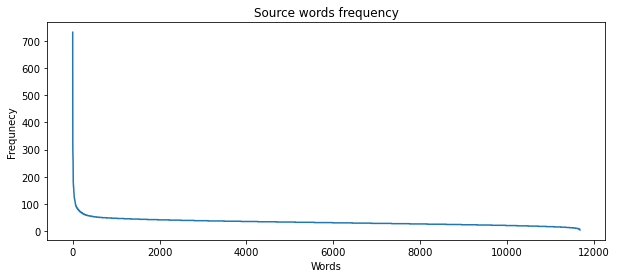

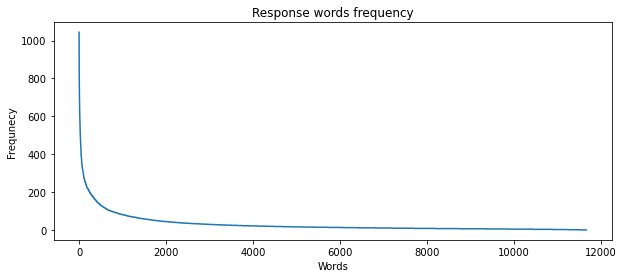

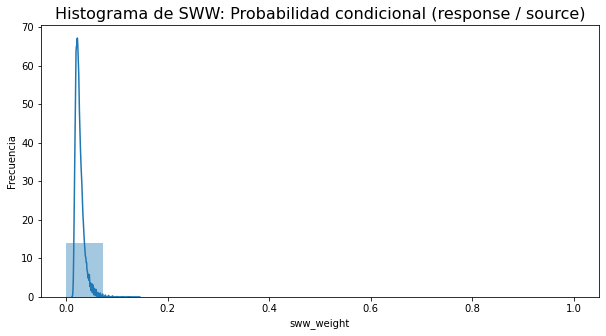

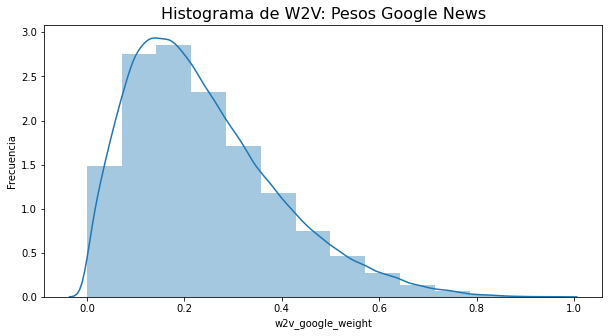

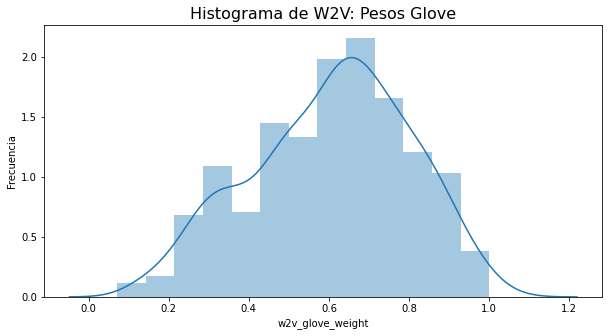

In [22]:
summary(dataset)




---  

###  Referencias

* [Glove word embedding](https://nlp.stanford.edu/projects/glove/)
* [Elmo word embedding](https://allennlp.org/elmo)
* [Basics of Using Pre-trained GloVe Vectors in Python](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)
* [Ejemplo word2vect](https://colab.research.google.com/drive/1YcplHjDL1M6G9K62W4GyUbic0OxOt8GZ?usp=sharing)
* [Ejemplo carga de dataset](https://colab.research.google.com/drive/1Qlq56GM6xERVpy6FAJhS5XCqaAKGlGtD?usp=sharing)
* [Pandas pipelines](https://calmcode.io/pandas-pipe/end.html)
* [Python logger](https://www.youtube.com/watch?v=g8nQ90Hk328&list=PLi01XoE8jYohWFPpC17Z-wWhPOSuh8Er-&index=17)
* [Dataset](https://smallworldofwords.org/en/project/research)